In [4]:
import pandas as pd
import numpy as np

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [17]:
import xgboost

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

In [7]:
import ta
import talib
from tech_indicators import stoch,stoch_signal

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [49]:
import warnings

warnings.filterwarnings("ignore")

## Preparing Data 


In [7]:
np.random.seed(999)

In [8]:
def zscore_func_improved(x,window_size=20):
    rolling_mean=x.rolling(window=window_size).mean().bfill()
    rolling_std = x.rolling(window=window_size).std().bfill()
    return (x-rolling_mean)/rolling_std

In [9]:
fcpo_data_daily=pd.read_hdf('processed_dta.h5','fcpo_data_daily')
fcpo_data_hourly=pd.read_hdf('processed_dta.h5','fcpo_data_hourly')

In [10]:
fcpo_daily_tind=pd.read_hdf('processed_dta.h5','fcpo_daily_tind')
fcpo_daily_cdlind=pd.read_hdf('processed_dta.h5','fcpo_daily_cdlind')

In [11]:
fcpo_daily_feats=fcpo_daily_tind.merge(fcpo_daily_cdlind,left_index=True,right_index=True)

In [64]:
## using the normalized data for feature engineering
#fcpo_data_daily[['Open','High','Low','Close']]=fcpo_data_daily[['Open','High','Low','Close']].apply(lambda x: zscore_func_improved(x))
## using the subset of data for training to exclude 2008 oil crisis
#fcpo_data_daily=fcpo_data_daily['2010-01-01':]
### TODO
## use tpot (auto-ml) for the best model of the data
## use features generated from previous time stamps


## Using Prophet for forecasting

In [10]:
#from fbprophet import Prophet
#prophet_model=Prophet()
#prophet_data_df=fcpo_data_daily['Close'].reset_index()
#prophet_data_df=prophet_data_df.rename(columns={'Date':'ds','Close':'y'})
#prophet_model.fit(prophet_data_df)

#prophet_forecast=prophet_model.make_future_dataframe(periods=365)
#prophet_forecast=prophet_model.predict(prophet_forecast)
#prophet_model.plot(prophet_forecast)

## Machine Learning models

In [12]:
def build_modeling_data(fcpo_data_daily,fcpo_feats,target_label='lprofit_ind',split_date='2017-01-01'):
    fcpo_train=fcpo_feats[:split_date]
    fcpo_test = fcpo_feats[split_date:]

    fcpo_train=fcpo_train.merge(fcpo_data_daily[['Open','prev_open_change_pct',target_label]],left_index=True,right_index=True)
    fcpo_traindata=fcpo_train.iloc[:,0:-1]
    fcpo_trainlabels=fcpo_train.iloc[:,-1:]
    
    fcpo_test=fcpo_test.merge(fcpo_data_daily[['Open','prev_open_change_pct',target_label]],left_index=True,right_index=True)
    fcpo_testdata=fcpo_test.iloc[:,0:-1]
    fcpo_testlabels=fcpo_test.iloc[:,-1]
    return fcpo_traindata,fcpo_trainlabels,fcpo_testdata,fcpo_testlabels

In [13]:
def buil_cross_validated_model(ml_model,traindata,trainlabels,tsplit,scoring_metric='roc_auc'):
    ml_cval_scores=cross_val_score(ml_model,traindata,np.ravel(trainlabels),
                                       scoring=scoring_metric,cv=tsplit)
    ml_model.fit(traindata,np.ravel(trainlabels))
    return ml_model,ml_cval_scores

### Time-series cross validation

In [14]:
fcpo_tsplit=TimeSeriesSplit(n_splits=3)

### Search for Best fitting parameters

In [17]:
## Use the RandomSearch funciton to find the best hyper parameters of Random forrests
rf_param_dist = {"max_features": [6,12],
                  "min_samples_split": [2,4,6],
                  "min_samples_leaf": [1,2,4],
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}

In [157]:
%%time
rf_lprofit_rsearch=RandomizedSearchCV(RandomForestClassifier(n_estimators=500,max_depth=12,n_jobs=-1),
                                      rf_param_dist,cv=fcpo_tsplit,scoring='roc_auc',n_iter=50,n_jobs=-1)

rf_lprofit_rsearch=rf_lprofit_rsearch.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

CPU times: user 11 s, sys: 200 ms, total: 11.2 s
Wall time: 3min 23s


## Long call trading model 

In [15]:
fcpo_lprofit_traindata,fcpo_lprofit_trainlabels,fcpo_lprofit_testdata,fcpo_lprofit_testlabels=build_modeling_data(fcpo_data_daily,
                                                                                     fcpo_daily_feats,'lprofit_ind_2pct','2016-01-01')

In [97]:
### Compute cross-validation scores using time-series splits for a defined configuration ###
rf_lprofit= RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_split=2,
                                  min_samples_leaf=2,criterion='gini')
rf_lprofit,rf_lprofit_cval_scores=buil_cross_validated_model(rf_lprofit,fcpo_lprofit_traindata,fcpo_lprofit_trainlabels,
                                                                fcpo_tsplit)

rf_lprofit_test_proba=rf_lprofit.predict_proba(fcpo_lprofit_testdata)
rf_lprofit_test_predlabels=rf_lprofit.predict(fcpo_lprofit_testdata)

#### GBM

In [98]:
gbm_lprofit=GradientBoostingClassifier(n_estimators=200,max_depth=15,min_samples_leaf=4,
                                       min_samples_split=4,learning_rate=0.1)
gbm_lprofit_cval_scores=cross_val_score(gbm_lprofit,fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels),
                                       scoring='roc_auc',cv=fcpo_tsplit)
gbm_lprofit.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

gbm_lprofit_test_proba=gbm_lprofit.predict_proba(fcpo_lprofit_testdata)
gbm_lprofit_test_predlabels=gbm_lprofit.predict(fcpo_lprofit_testdata)

### XGBoost

In [51]:
xgb_lprofit=xgboost.XGBClassifier(objective='binary:logistic',max_depth=15,n_estimators=300,learning_rate=0.05,gamma=0,
                                    subsample=0.8,colsample_bytree=0.8,n_jobs=-1)

xgb_lprofit.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels),eval_set=[(fcpo_lprofit_traindata, fcpo_lprofit_trainlabels)],
                eval_metric="auc",early_stopping_rounds=10,verbose=False)

xgb_lprofit_test_predlabels=fcpo_xgboost.predict(fcpo_lprofit_testdata)

## Short call trading model 

In [99]:
fcpo_sprofit_traindata,fcpo_sprofit_trainlabels,fcpo_sprofit_testdata,fcpo_sprofit_testlabels=build_modeling_data(fcpo_data_daily,
                                                                                            fcpo_daily_feats,'sprofit_ind_2pct','2016-01-01')

#### Random Forrest

In [100]:
rf_sprofit= RandomForestClassifier(n_estimators=300,max_depth=12,min_samples_split=4,
                                  min_samples_leaf=4,criterion='entropy')
rf_sprofit,rf_sprofit_cval_scores=buil_cross_validated_model(rf_sprofit,fcpo_sprofit_traindata,fcpo_sprofit_trainlabels,
                                                                fcpo_tsplit)

rf_sprofit_test_proba=rf_sprofit.predict_proba(fcpo_sprofit_testdata)
rf_sprofit_test_predlabels=rf_sprofit.predict(fcpo_sprofit_testdata)

#### GBM 

In [101]:
gbm_sprofit=GradientBoostingClassifier(n_estimators=200,max_depth=15,min_samples_leaf=4,
                                       min_samples_split=4,learning_rate=0.1)
gbm_sprofit,gbm_sprofit_cval_scores=buil_cross_validated_model(gbm_sprofit,fcpo_sprofit_traindata,fcpo_sprofit_trainlabels,
                                                                fcpo_tsplit)
gbm_sprofit_test_proba=gbm_sprofit.predict_proba(fcpo_sprofit_testdata)
gbm_sprofit_test_predlabels=gbm_sprofit.predict(fcpo_sprofit_testdata)

## Evaluation of Models

### Precision and Recall

In [102]:
print("precision : {pscore}, recall: {rscore}".format(pscore=round(precision_score(fcpo_lprofit_testlabels,rf_lprofit_test_predlabels),2),
                                                      rscore=round(recall_score(fcpo_lprofit_testlabels,rf_lprofit_test_predlabels),2)))

precision : 0.5, recall: 0.04


In [103]:
print("precision : {pscore}, recall: {rscore}".format(pscore=round(precision_score(fcpo_lprofit_testlabels,gbm_lprofit_test_predlabels),2),
                                                      rscore=round(recall_score(fcpo_lprofit_testlabels,gbm_lprofit_test_predlabels),2)))

precision : 0.41, recall: 0.18


In [48]:
print("precision : {pscore}, recall: {rscore}".format(pscore=round(precision_score(fcpo_lprofit_testlabels,xgb_lprofit_test_predlabels),2),
                                                      rscore=round(recall_score(fcpo_lprofit_testlabels,xgb_lprofit_test_predlabels),2)))

precision : 0.42, recall: 0.14


In [104]:
print("precision : {pscore}, recall: {rscore}".format(pscore=round(precision_score(fcpo_sprofit_testlabels,rf_sprofit_test_predlabels),2),
                                                      rscore=round(recall_score(fcpo_sprofit_testlabels,rf_sprofit_test_predlabels),2)))

precision : 0.41, recall: 0.07


In [105]:
print("precision : {pscore}, recall: {rscore}".format(pscore=round(precision_score(fcpo_sprofit_testlabels,gbm_sprofit_test_predlabels),2),
                                                      rscore=round(recall_score(fcpo_sprofit_testlabels,gbm_sprofit_test_predlabels),2)))

precision : 0.35, recall: 0.17


## Financial Metrics

The final objective of this study is to improve the ROI, hence we are focused on creating a score-card to measure the investement metrics to select the final model,

- Total Returns
- Maximum Drawdown
- Number of Wins
- Number of Losses

**Calculation of Returns**

* When the sprofit_indicator is true, then return is (open_price - next_low_price) - (commission_price),
* Else when the sprofit_indicator is false, the model waits until the end of the day before selling it hence the return is (open_price - next_close_price) - (commission_price)


In [117]:
def calculate_short_returns(x,profit_field,pred_field,commission_price,num_units,profit_thr=0.03):
    return_myr=0
    #when the prediction is zero, the model accumulates no returns
    if x[pred_field]==0:
        return_myr=0
    #when the model makes a prediction
    elif x[pred_field]==1:
        if x[profit_field]==1:
        #when it is correct, sell it off when it reaches max x% profit zone
            return_myr=(min((x['Open']-x['Low']),(x['Open']-x['next_1low']),(x['Open']-x['Open']*(1-profit_thr)))*num_units)-commission_price
        #when it went wrong, sell it off when it reaches x% loss or wait till it reaches eod
        elif x[profit_field]==0:
            return_myr=(max((x['Open']-x['next_1close']),(x['Open']-x['Open']*(1+profit_thr)))*num_units)-commission_price
    return return_myr

def calculate_long_returns(x,profit_field,pred_field,commission_price,num_units,profit_thr=0.03):
    return_myr=0
    #when the prediction is zero, the model accumulates no returns
    if x[pred_field]==0:
        return_myr=0
    #when the model makes a prediction
    elif x[pred_field]==1:
        #when it is correct, sell it off when it reaches max x% profit zone
        if x[profit_field]==1:
            return_myr=(min((x['High']-x['Open']),(x['next_1high']-x['Open']),(x['Open']*(1+profit_thr)-x['Open']))*num_units)-commission_price
        #when it went wrong, sell it off when it reaches x% loss or wait till it reaches eod
        elif x[profit_field]==0:
            return_myr=(max((x['next_1close']-x['Open']),(x['Open']*(1-profit_thr)-x['Open']))*num_units)-commission_price
    return return_myr

def max_drawdown(X):
    mdd = 0
    peak = X[0]
    mdd_peak=0
    mdd_x=0
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
            mdd_peak=peak
            mdd_x=x
    return mdd_peak,mdd_x,mdd 

In [134]:
fcpo_eval_df=fcpo_data_daily[['Open','High','Low','next_1low','next_1high','next_1close','lprofit_ind_1pct','sprofit_ind_1pct']].merge(
    pd.DataFrame(rf_lprofit_test_predlabels,columns=['rf_lprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(gbm_lprofit_test_predlabels,columns=['gbm_lprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(gbm_sprofit_test_predlabels,columns=['gbm_sprofit_prediction'],index=fcpo_sprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(rf_sprofit_test_predlabels,columns=['rf_sprofit_prediction'],index=fcpo_sprofit_testlabels.index),
            left_index=True,right_index=True)

fcpo_eval_df['lprofit_returns']=fcpo_eval_df.apply(lambda x: calculate_long_returns(x,'lprofit_ind_1pct','gbm_lprofit_prediction',30,25,0.02),axis=1)
fcpo_eval_df=fcpo_eval_df.assign(cummulative_lprofit_returns=fcpo_eval_df['lprofit_returns'].cumsum())

fcpo_eval_df['sprofit_returns']=fcpo_eval_df.apply(lambda x: calculate_short_returns(x,'sprofit_ind_1pct','gbm_sprofit_prediction',30,25,0.02),axis=1)
fcpo_eval_df=fcpo_eval_df.assign(cummulative_sprofit_returns=fcpo_eval_df['sprofit_returns'].cumsum())

fcpo_eval_df=fcpo_eval_df.assign(cummulative_lprofit_returns=fcpo_eval_df['cummulative_lprofit_returns']+15000,
            cummulative_sprofit_returns=fcpo_eval_df['cummulative_sprofit_returns']+15000)

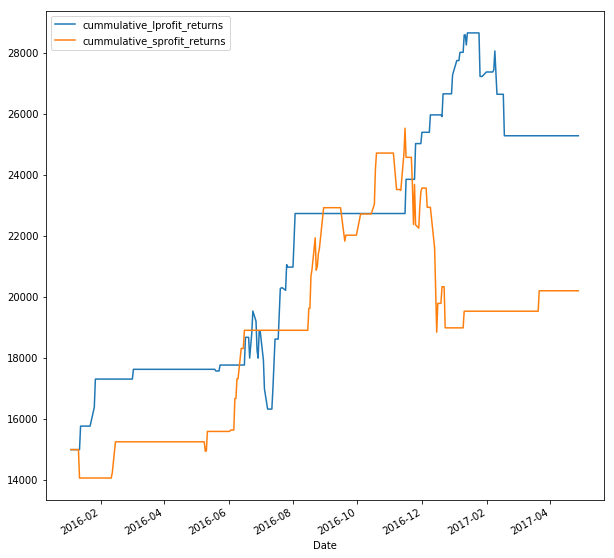

In [135]:
plt.figure(figsize=(10,10))
fcpo_eval_df['2016-01-01':'2017-05-01']['cummulative_lprofit_returns'].plot()
fcpo_eval_df['2016-01-01':'2017-05-01']['cummulative_sprofit_returns'].plot()
plt.legend()

In [136]:
max_drawdown(fcpo_eval_df['2016-01-01':'2017-05-01']['cummulative_lprofit_returns'])

(19538.0, 16327.5, 0.16432081072781246)

In [138]:
max_drawdown(fcpo_eval_df['2016-01-01':'2017-05-01']['cummulative_sprofit_returns'])

(25528.000000000022, 18845.50000000001, 0.2617713882795364)